# A Physics-Informed Neural Network approach for compartmental epidemiological models


Notebooks for PINN solution of the SIR compartmental model presented [in the paper](https://arxiv.org/abs/2311.09944):

```
@misc{millevoi2023physicsinformed,
      title={A Physics-Informed Neural Network approach for compartmental epidemiological models}, 
      author={Caterina Millevoi and Damiano Pasetto and Massimiliano Ferronato},
      year={2023},
      eprint={2311.09944},
      archivePrefix={arXiv},
      primaryClass={math.NA}
}
```

Note: The uploaded code is related to Case 1. For further information please contact the corresponding author.

In [ ]:
import sciann as sn
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.integrate import odeint

## Case 1: constant trasmission rate

In [2]:
# SIR parameters
N     = 56e6 # (-) population (Italy)
delta = 1/5  # (1/T) 5 = mean reproduction period 
r0    = 3.   # (-) basic reproduction number (estimate for Italy) 

beta = delta*r0 # (1/T) transmission rate 
t0   = 0.       # (days) initial time
tf = 90.        # (days) final time

C = 1e5
C1 = tf*C/N   
C2 = tf*delta

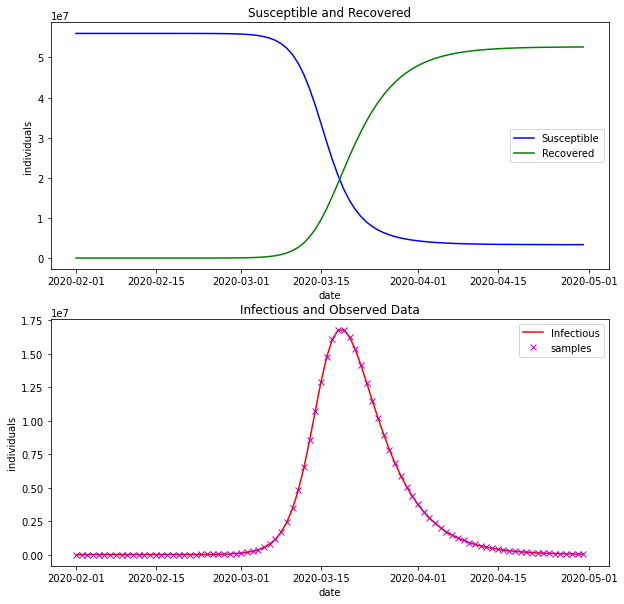

In [3]:
# Function to define the SIR model
def SIR(x, t, delta, beta, N, t0):
    S, I, R = x
    lambda_val = beta*I/N;
    dSdt = -lambda_val*S
    dIdt = lambda_val*S - delta*I
    dRdt = delta*I
    return [dSdt, dIdt, dRdt]

# Initial conditions
S0 = N-1
I0 = 1
R0 = 0
x0 = [S0, I0, R0]

# Time span
timespan = np.arange('2020-02-01', '2020-05-01', dtype='datetime64[D]')
tspan = timespan.astype(int)

# Solve the ODE
x = odeint(SIR, x0, tspan, args=(delta, beta, N, tspan[0]))

S_data = x[:, 0]
I_data = x[:, 1]
R_data = x[:, 2]

# Generate observations
I_obs = np.random.poisson(I_data)

# Plot results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(timespan, S_data, 'b', label='Susceptible')
plt.plot(timespan, R_data, 'g', label='Recovered')
plt.legend()
plt.xlabel('date')
plt.ylabel('individuals')
plt.title('Susceptible and Recovered')
plt.subplot(2, 1, 2)
plt.plot(timespan, I_data, 'r', label='Infectious')
plt.plot(timespan, I_obs, 'xm', label='samples')
plt.legend()
plt.xlabel('date')
plt.ylabel('individuals')
plt.title('Infectious and Observed Data')
plt.show()

In [4]:
# Scale data
t_data = np.arange(t0,tf)
t_test = np.arange(t0,tf,0.1)

I_obs_sc  = I_obs/C
I_data_sc = I_data/C
t_data_sc = t_data/tf
t_test_sc = t_test/tf

# Weekly data
weekly = False
if weekly:
    I_obs_sc = I_obs_sc[::7]

In [5]:
# Training parameters
loss_err  = 'mse'
optimizer = 'adam'
adaptive_NTK = {'method':'NTK','freq':100}

### Joint

In [6]:
sn.reset_session()

In [7]:
# Build NN - Joint
ts  = sn.Variable('ts')
Ss = sn.Functional('Ss', ts, 4*[50], output_activation='square')
Is = sn.Functional('Is', ts, 4*[50], output_activation='square')

Beta = sn.Parameter(name='Beta', inputs=ts, non_neg=True)

Rs = N/C-Is-Ss

In [8]:
# Initial Conditions
L_S0 = sn.rename((Ss-S0/C)*(1-sn.sign(ts-t0/tf)), 'L_S0')
L_I0 = sn.rename((Is-I0/C)*(1-sn.sign(ts-t0/tf)), 'L_I0')
L_R0 = sn.rename((Rs-R0/C)*(1-sn.sign(ts-t0/tf)), 'L_R0')

# ODEs
L_dSdt = sn.rename((sn.diff(Ss,ts)+C1*Beta*Is*Ss), 'L_dSdt')
L_dIdt = sn.rename((sn.diff(Is,ts)-C1*Beta*Is*Ss+C2*Is), 'L_dIdt')
L_dRdt = sn.rename((sn.diff(Rs,ts)-C2*Is), 'L_dRdt')

In [9]:
# Build the model - Joint
loss_joint = [sn.PDE(L_dSdt),  sn.PDE(L_dIdt),  sn.PDE(L_dRdt), 
              sn.PDE(L_S0),    sn.PDE(L_I0),    sn.PDE(L_R0),
              sn.Data(Ss*0.0), sn.Data(Rs*0.0), sn.Data(Is)]

m = sn.SciModel(ts, loss_joint, loss_err, optimizer)

In [10]:
# Training points
Nc = 6000    # collocation points

I_obs_sc     = I_obs_sc.reshape(-1,1)
t_train_ode  = np.random.uniform(np.log1p(t0/tf), np.log1p(1.), Nc)
t_train_ode  = np.exp(t_train_ode) - 1.
if weekly:
    t_train  = np.concatenate([t_data_sc[::7].reshape(-1,1), t_train_ode.reshape(-1,1)])
    ids_data = np.arange(t_data_sc[::7].size,dtype=np.intp)
else:
    t_train  = np.concatenate([t_data_sc.reshape(-1,1), t_train_ode.reshape(-1,1)])
    ids_data = np.arange(t_data_sc.size,dtype=np.intp)

loss_train   = ['zeros']*8+[(ids_data,I_obs_sc)]
epochs_joint = 5000
batch_size   = 100

log_params   = {'parameters': Beta,'freq':1}

In [ ]:
# Train the model
time1 = time.time()
h     = m.train(t_train,
                loss_train,
                epochs=epochs_joint,
                batch_size=batch_size,
                log_parameters=log_params,
                adaptive_weights=adaptive_NTK,
                verbose=1
               )
time2 = time.time()

In [12]:
print(f'Training time: {time2-time1}')

Training time: 1962.2148821353912


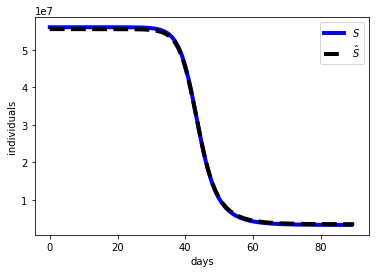

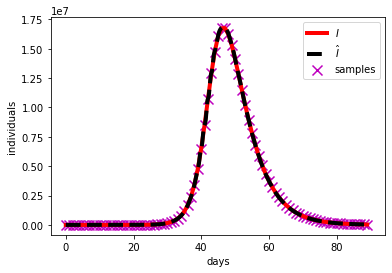

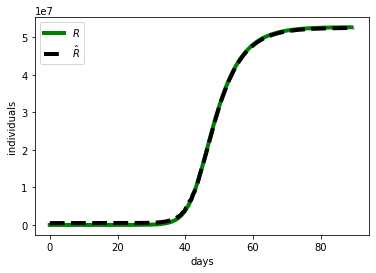

In [13]:
# Get predictions
S_pred_test = Ss.eval(m, t_test_sc)
I_pred_test = Is.eval(m, t_test_sc)
R_pred_test = Rs.eval(m, t_test_sc)

# Plot results
plt.plot(t_data, S_data, c='b',linewidth=4)
plt.plot(t_test,S_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$S$', '$\hat{S}$'])
plt.show()

plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test*C, '--', c='k', linewidth=4)
if weekly: plt.scatter(t_data[::7],I_obs[::7], marker='x', c='m', s=100)
else: plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

plt.plot(t_data, R_data, c='g',linewidth=4)
plt.plot(t_test,R_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$R$', '$\hat{R}$'])
plt.show()

In [14]:
# Evaluate errors
S_pred = Ss.eval(m, t_data_sc)*C
I_pred = Is.eval(m, t_data_sc)*C
R_pred = Rs.eval(m, t_data_sc)*C
beta_pred = Beta.eval(m, t_data_sc)

S_err = np.linalg.norm(S_data-S_pred,2)/np.linalg.norm(S_data,2)
I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
R_err = np.linalg.norm(R_data-R_pred,2)/np.linalg.norm(R_data,2)
beta_err = abs(beta_pred[0]-beta)/beta

print(f'S error: {S_err:.3e}')
print(f'I error: {I_err:.3e}')
print(f'R error: {R_err:.3e}')
print(f'Beta error: {beta_err:.3e}')

Input and output dimensions need re-adjustment for post-processing.
S error: 9.416e-03
I error: 2.542e-03
R error: 1.088e-02
Beta error: 2.186e-02


In [15]:
# Save training history and model
with open('hJoint.txt', 'wb') as myFile:
    pickle.dump(h.history, myFile)
myFile.close()

m.save_weights('mJoint.hdf5')

### Split

In [16]:
sn.reset_session()

In [17]:
# Build NN - Split - only data regression
ts  = sn.Variable('ts')
Isc = sn.Functional('Isc', ts, 4*[50], output_activation='square')

In [18]:
# Build the model - Split - only data regression
loss_data = sn.Data(Isc)

m_data = sn.SciModel(ts, loss_data, loss_err, optimizer)

In [19]:
# Training points - Split - only data regression
if weekly: 
    t_data_train = t_data_sc[::7]
    epochs_data  = 1000
    batch_data   = 13
else: 
    t_data_train = t_data_sc
    epochs_data  = 3000
    batch_data   = 10

In [ ]:
# Train the model - Split - only data regression
time1_data = time.time()
h_data     = m_data.train(t_data_train, 
                          I_obs_sc, 
                          epochs=epochs_data,
                          batch_size=batch_data,
                          verbose=1)
time2_data = time.time()

In [21]:
print(f'Training time: {time2_data-time1_data}')

Training time: 311.85214710235596


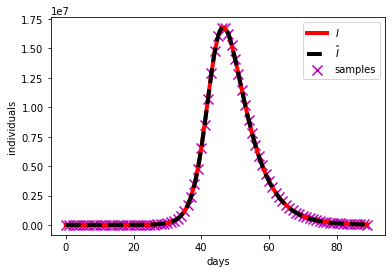

In [22]:
# Get predictions
Isc_pred = Isc.eval(m_data, t_test_sc)

# Plot results
plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,Isc_pred*C, '--', c='k', linewidth=4)
if weekly: plt.scatter(t_data[::7],I_obs[::7], marker='x', c='m', s=100)
else: plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

In [23]:
# Evaluate errors
Isc_pred = Isc.eval(m_data,t_data_sc)
Isc_err = np.linalg.norm(I_data_sc-Isc_pred,2)/np.linalg.norm(I_data_sc,2)
print(f'Isc error: {Isc_err:.3e}')

Isc error: 2.644e-03


In [24]:
# Fix the I-NN weights
Isc_weights = Isc.get_weights()

Is = sn.Functional('Is', ts, 4*[50], output_activation='square', trainable=False)
Is.set_weights(Isc_weights)

In [25]:
# Build NN - Split - fully physics-informed
Ss = sn.Functional('Ss', ts, 4*[50], output_activation='square')

Beta = sn.Parameter(name='Beta', inputs=ts, non_neg=True)

Rs = N/C-Is-Ss

In [26]:
# Initial Conditions
L_S0 = sn.rename((Ss-S0/C)*(1-sn.sign(ts-t0/tf)), 'L_S0')
L_R0 = sn.rename((Rs-R0/C)*(1-sn.sign(ts-t0/tf)), 'L_R0')

# ODEs
L_dSdt = sn.rename((sn.diff(Ss,ts)+C1*Beta*Is*Ss), 'L_dSdt')
L_dIdt = sn.rename((sn.diff(Is,ts)-C1*Beta*Is*Ss+C2*Is), 'L_dIdt')
L_dRdt = sn.rename((sn.diff(Rs,ts)-C2*Is), 'L_dRdt')

In [27]:
# Build the model - Split - fully physics-informed
loss_ode = [sn.PDE(L_dSdt),  sn.PDE(L_dIdt),  sn.PDE(L_dRdt), 
            sn.PDE(L_S0), sn.PDE(L_R0), 
            sn.Data(Ss*0.0), sn.Data(Rs*0.0), sn.Data(Is*0.0)]

m_ode = sn.SciModel(ts, loss_ode, loss_err, optimizer)


loss_train_ode = ['zeros']*8

epochs_ode = 1000
log_params   = {'parameters': Beta, 'freq':1}

In [ ]:
# Train the model - Split - fully physics-informed
time1_ode = time.time()
h_ode     = m_ode.train(t_train_ode,
                        loss_train_ode,
                        epochs=epochs_ode,
                        batch_size=batch_size,
                        log_parameters=log_params,
                        adaptive_weights=adaptive_NTK,
                        verbose=1)
time2_ode = time.time()

In [29]:
print(f'Training time: {time2_ode-time1_ode}')

Training time: 378.5633165836334


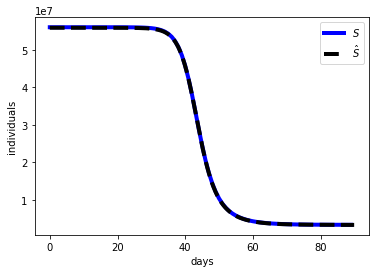

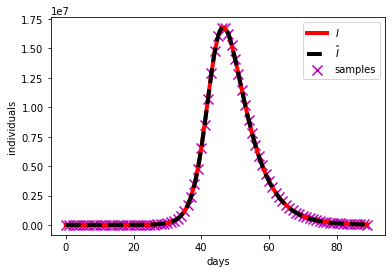

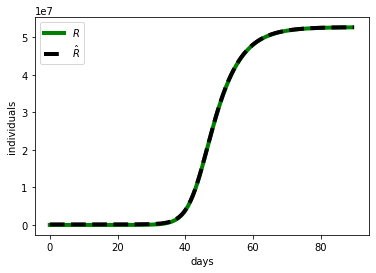

In [30]:
# Get predictions
S_pred_test = Ss.eval(m_ode, t_test_sc)
I_pred_test = Is.eval(m_ode, t_test_sc)
R_pred_test = Rs.eval(m_ode, t_test_sc)

# Plot results
plt.plot(t_data, S_data, c='b',linewidth=4)
plt.plot(t_test,S_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$S$', '$\hat{S}$'])
plt.show()

plt.plot(t_data,I_data, c='r', linewidth=4)
plt.plot(t_test,I_pred_test*C, '--', c='k', linewidth=4)
if weekly: plt.scatter(t_data[::7],I_obs[::7], marker='x', c='m', s=100)
else: plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$I$','$\hat{I}$','samples'])
plt.show()

plt.plot(t_data, R_data, c='g',linewidth=4)
plt.plot(t_test,R_pred_test*C, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$R$', '$\hat{R}$'])
plt.show()

In [31]:
# Evaluate errors
S_pred = Ss.eval(m_ode, t_data_sc)*C
I_pred = Is.eval(m_ode, t_data_sc)*C
R_pred = Rs.eval(m_ode, t_data_sc)*C
beta_pred = Beta.eval(m_ode, t_data_sc)

S_err = np.linalg.norm(S_data-S_pred,2)/np.linalg.norm(S_data,2)
I_err = np.linalg.norm(I_data-I_pred,2)/np.linalg.norm(I_data,2)
R_err = np.linalg.norm(R_data-R_pred,2)/np.linalg.norm(R_data,2)
beta_err = abs(beta_pred[0]-beta)/beta

print(f'S error: {S_err:.3e}')
print(f'I error: {I_err:.3e}')
print(f'R error: {R_err:.3e}')
print(f'Beta error: {beta_err:.3e}')

Input and output dimensions need re-adjustment for post-processing.
S error: 2.608e-03
I error: 2.644e-03
R error: 3.185e-03
Beta error: 5.143e-03


In [32]:
# Save training histories and models
with open('hSplit_data.txt', 'wb') as myFile:
    pickle.dump(h_data.history, myFile)
myFile.close()

m_data.save_weights('mSplit_data.hdf5')

with open('hSplit_ode.txt', 'wb') as myFile:
    pickle.dump(h_ode.history, myFile)
myFile.close()

m_ode.save_weights('mSplit_ode.hdf5')

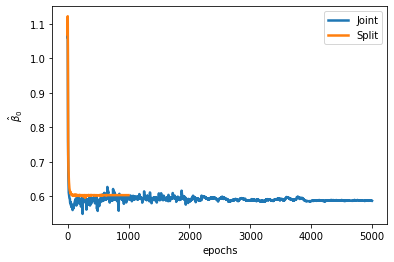

In [33]:
# Beta identification comparison
plt.plot(h.history['Beta'], linewidth=2.5)
plt.plot(h_ode.history['Beta'],linewidth=2.5)
plt.legend(['Joint', 'Split'])
plt.ylabel(r'$\hat{\beta}_0$')
plt.xlabel('epochs')
plt.show()